# Процесс создания модели

Импортируем необходимые библиотеки. Для работы нам потребуется, в основном библиотеки pandas и sklearn. Если какая-либо библиотека отсутствует и не установлена на рабочей машине, ее можно установить, набрав команду 'pip install library_name' в командной строке.

In [127]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold

from sklearn.linear_model import LogisticRegression as log_reg, LinearRegression as lr_reg
from sklearn.ensemble import RandomForestClassifier as rf, RandomForestRegressor as rf_reg
from sklearn.ensemble import GradientBoostingClassifier as gb, GradientBoostingRegressor as gb_reg

import sklearn.cluster as cluster

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import time
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

Загрузим данные для работы-датасет с информацией по различным фруктам и их параметрам.

In [129]:
fruits = pd.read_table('fruit_data_with_colors.txt',sep=',')
fruits.head()

,fruit_label,fruit_name,mass,width,height,col_score
0,1,apple,192,8.4,7.3,0.55
1,1,apple,180,8.0,6.8,0.59
2,1,apple,176,7.4,7.2,0.60
3,2,mandarin,86,6.2,4.7,0.80
4,2,mandarin,84,6.0,4.6,0.79


Проведем первоначальный анализ данных. Для начала, посмотрим какие виды фруктов присутствуют в наборе данных. Для этого используем функцию unique() библиотеки pandas.

In [130]:
fruits.fruit_name.unique()

array(['apple', 'mandarin', 'orange', 'lemon'], dtype=object)

Оценим параметры данных (количество записей и столбцов).

In [131]:
fruits.shape

(59, 6)

Проверим данные на наличие пропущенных значений, используя функцию isnull().

In [133]:
fruits.isnull().values.any()

False

Посмотрим описательную статистику данных (среднее, стандартное отклонение, мин/макс значений и квартили). Данная операция легко выполняется с использованием pandas функции describe(). По значениям среднего, мин/макса и отклонения, сразу видно, что переменные имеют различные шкалы- к примеру шкала переменной mass значительно отличается от шкалы других переменных. Поэтому в дальнейшем мы должны провести шкалирование данных (стандартизацию) для того чтобы привести их к одной шкале. Это позволит нашей модели работать более точно. Если этого не делать, то переменная с большей шкалой будет иметь больший вес в модели ухудшая ее качество.

In [134]:
fruits.describe()

,fruit_label,mass,width,height,col_score
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.542373,163.118644,7.105085,7.693220,0.762881
std,1.208048,55.018832,0.816938,1.361017,0.076857
min,1.000000,76.000000,5.800000,4.000000,0.550000
25%,1.000000,140.000000,6.600000,7.200000,0.720000
50%,3.000000,158.000000,7.200000,7.600000,0.750000
75%,4.000000,177.000000,7.500000,8.200000,0.810000
max,4.000000,362.000000,9.600000,10.500000,0.930000


Подготовим данные к разработке модели классификации- выделим признаковое множество X и целевую переменную y. В данном случае мы будем предсказывать лейбл фруктов.

In [136]:
X = fruits[['mass', 'width', 'height', 'col_score']]
y = fruits['fruit_label']

Проведем корреляционный анализ с использованием функции corr(). Он позволит нам понять зависимости между переменными в наборе данных и очень полезен для отбора фичей для модели и проверки сгенерированных новых. Визуализацию осуществим в виде heatmap, используя библиотеку seaborn. На графике видна сильная взаимосвязь переменных mass и width и достаточно отчетливая связь переменных height и mass.

<IPython.core.display.Javascript object>


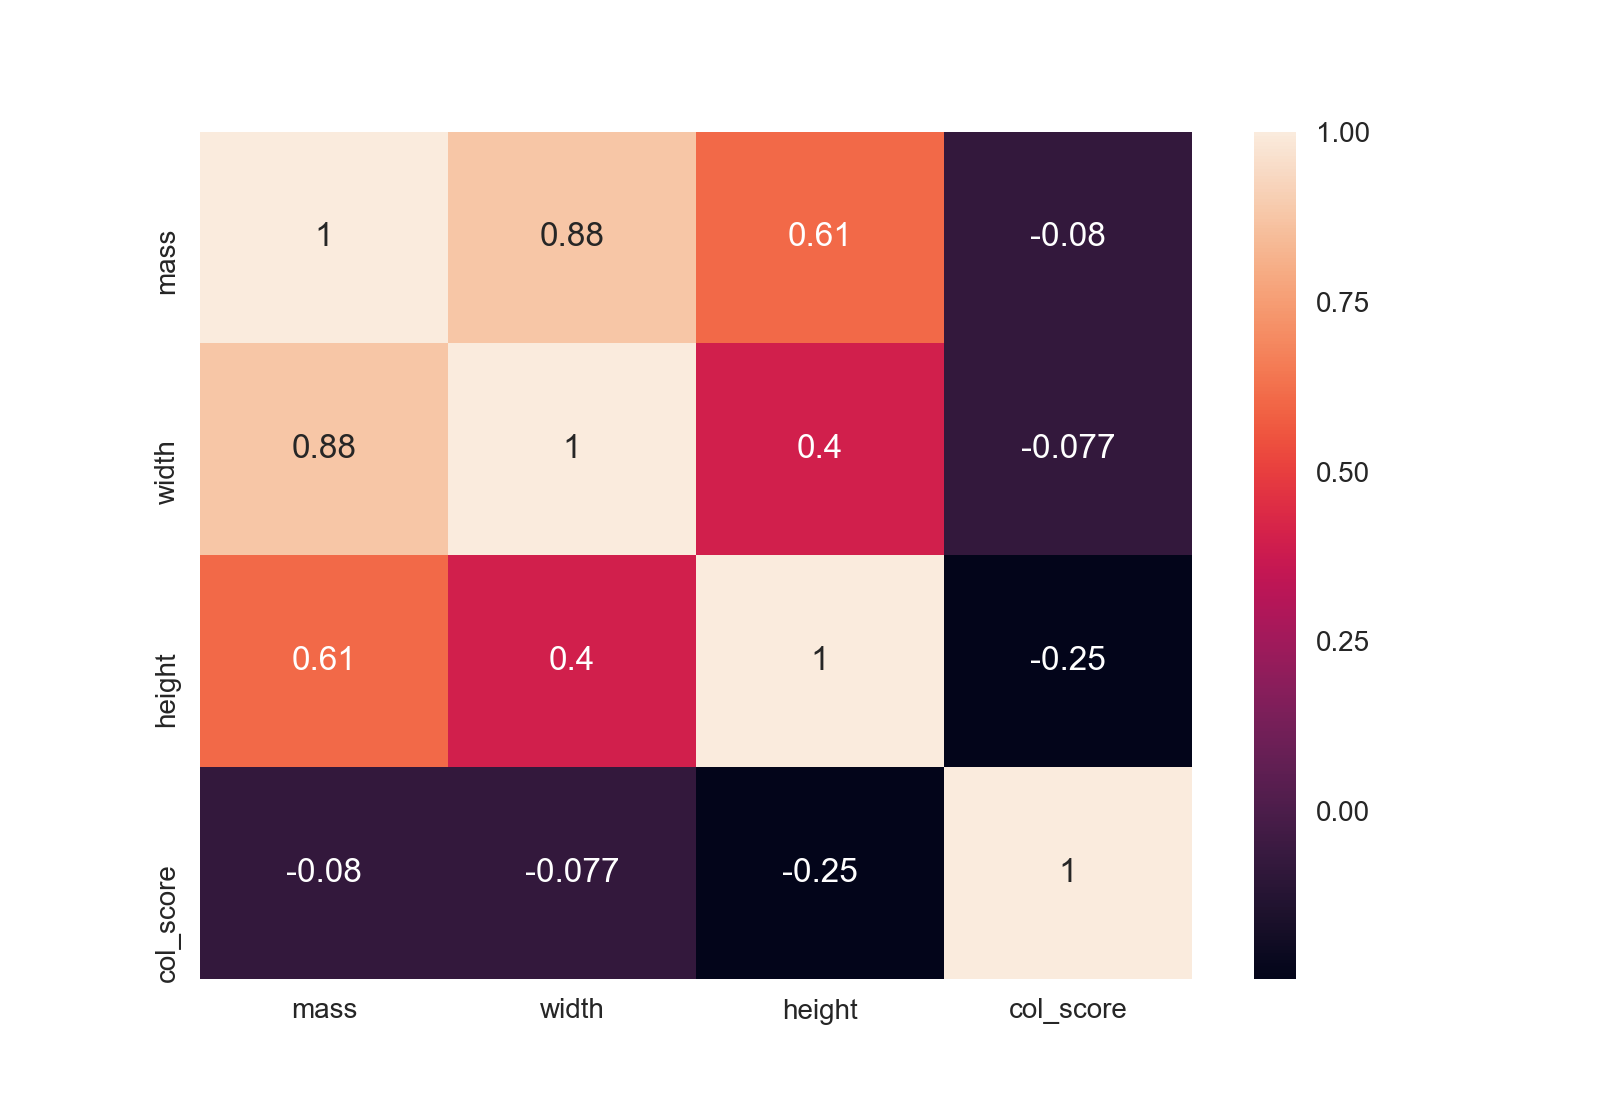

In [137]:
corr = X.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Построим scatter plot для дальнейшего анализа данных. Результаты построения показывают сильную зависимость переменной mass и width, ранее подтвержденную в ходе проведения корреляционного анализа. Также мы можем заметить, что хоть данные не имеют нормального распределения, однако распределение достаточно близко к нормальному. Поэтому нам не нужно будет осуществлять процедур по типу log трансформации для привода данных в нормальное распределение для улучшения работы модели и мы можем ограничиться только шкалированием переменных.

<IPython.core.display.Javascript object>


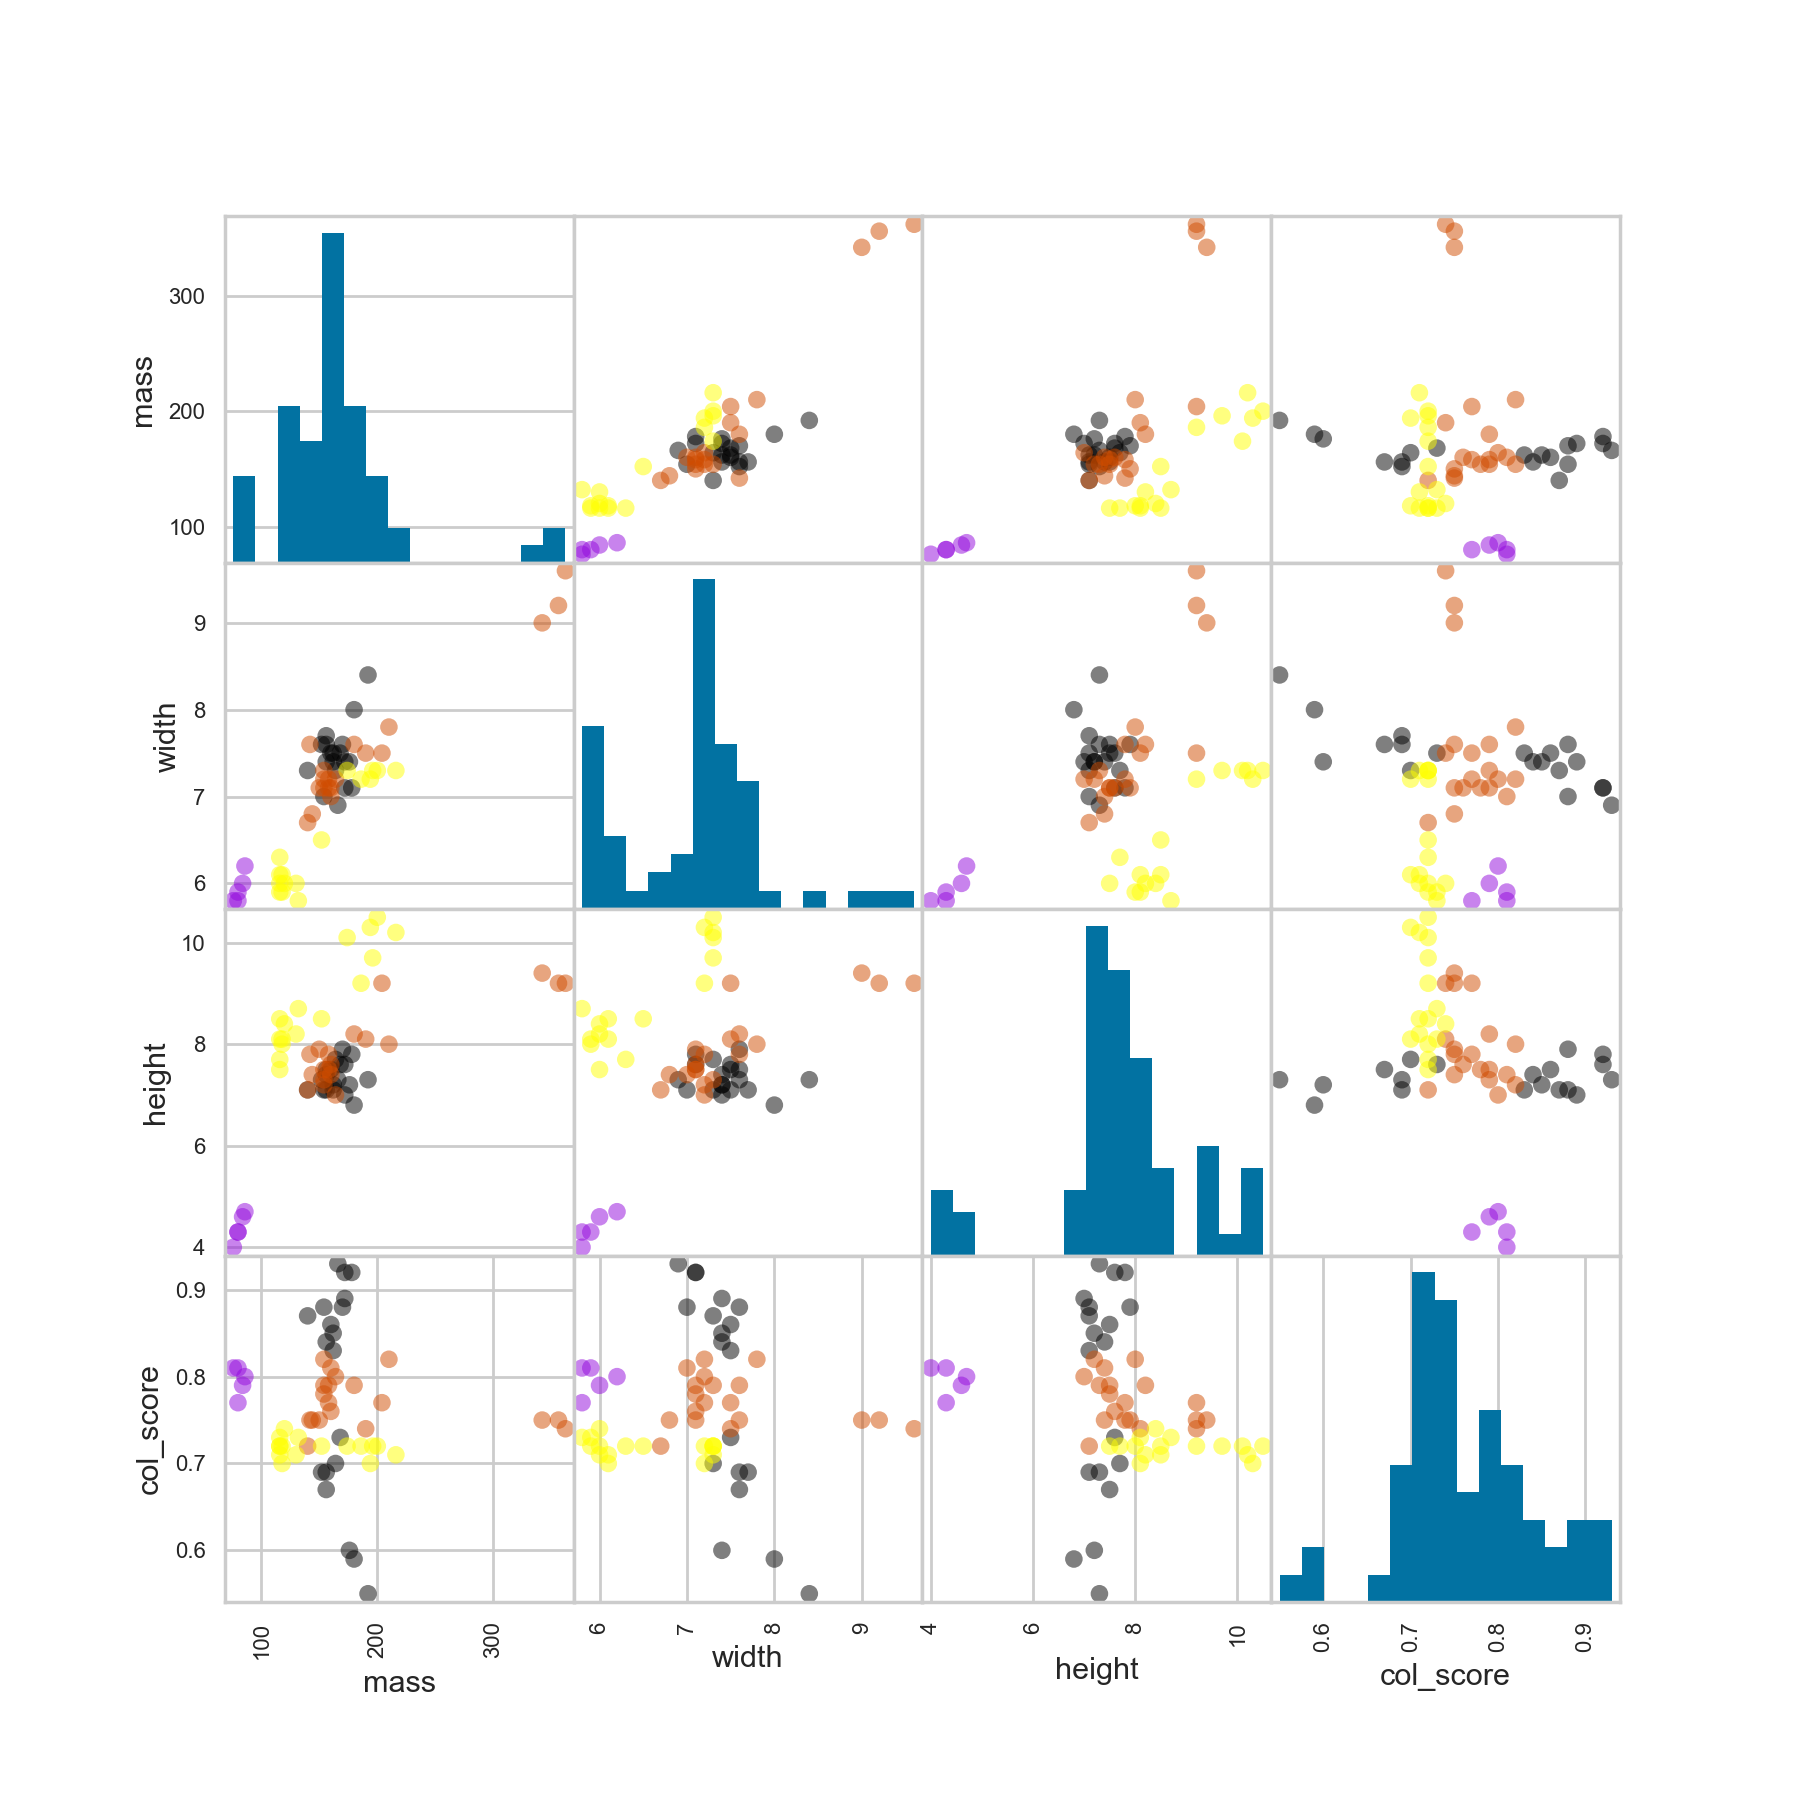

In [13]:
cmap = plt.get_cmap('gnuplot')
scatter = pd.scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap = cmap)

Проведем кросс валидацию данных для того, чтобы избежать переобучения модели. Используем подход KFold с n_folds=10, который является основным для данной процедуры. Его идея состоит в том, что тренировка модели происходит на k-1 выборках (фолдах), а валидация- на оставшемся фолде. Создадим функцию cv() в которой будет осуществляться процесс кросс-валидации. Данная функция будет принимать на вход признаковое множество X, целевую переменную y и выбранный алгоритм.

In [38]:
def cv(X,y,clf_class):
    
    kf = KFold(len(y),n_folds=10,shuffle=False)
    y_pred = y.copy()

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf = clf_class()
        clf.fit(X_train,y_train)

        y_pred[test_index] = clf.predict(X_test)
        
    return y_pred

Стандартизуем данные с использованием метода StandardScaler() из библиотеки sklearn. Этот процесс делает трансформацию значений к нулевому среднему и единичной дисперсии.

In [15]:
X = StandardScaler().fit_transform(X)

Для построения модели мультикласовой классификации будем использовать три модели: логистическую регрессию, Random Forest и градиентный бустинг. Проверять качество классификатора будем на следующих метриках: accuracy, f1_score, precision, recall. Они являются основными для оценки качества классификации.

In [16]:
print(accuracy_score(y,cv(X,y,log_reg)))
print(f1_score(y,cv(X,y,log_reg),average='weighted'))
print(precision_score(y,cv(X,y,log_reg),average='weighted'))
print(recall_score(y,cv(X,y,log_reg),average='weighted'))

0.3389830508474576
0.3327341208697141
0.3270189431704885
0.3389830508474576


In [34]:
print(accuracy_score(y,cv(X,y,rf)))
print(f1_score(y,cv(X,y,rf),average='weighted'))
print(precision_score(y,cv(X,y,rf),average='weighted'))
print(recall_score(y,cv(X,y,rf),average='weighted'))

0.8135593220338984
0.7845051930879553
0.8152107779226423
0.864406779661017


In [35]:
print(accuracy_score(y,cv(X,y,gb)))
print(f1_score(y,cv(X,y,gb),average='weighted'))
print(precision_score(y,cv(X,y,gb),average='weighted'))
print(recall_score(y,cv(X,y,gb),average='weighted'))

0.7796610169491526
0.7724346340822494
0.7826876513317191
0.7796610169491526


Попробуем улучшить качество логистической регрессии. Для этого используем подход GridSearch() который помогает найти оптимальные параметры для модели для конкретного датасета с использованием принципа кросс-валидации. Перепишем нашу функцию cv().

In [36]:
def cv(X,y,clf_class):
    
    kf = KFold(len(y),n_folds=10,shuffle=False)
    y_pred = y.copy()

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf = clf_class()
        clf.fit(X_train,y_train)
        
        penalty = ['l1', 'l2']
        C = np.logspace(0, 4, 10)
        hyperparameters = dict(C=C, penalty=penalty)
        
        clf = GridSearchCV(clf, hyperparameters, cv=10, verbose=0)
        
        best_model = clf.fit(X_train, y_train)

        y_pred[test_index] = best_model.predict(X_test)
        
    return y_pred

In [37]:
print(accuracy_score(y,cv(X,y,log_reg)))
print(f1_score(y,cv(X,y,log_reg),average='weighted'))
print(precision_score(y,cv(X,y,log_reg),average='weighted'))
print(recall_score(y,cv(X,y,log_reg),average='weighted'))

0.423728813559322
0.4144214542519627
0.40611202107961825
0.423728813559322


Также данные для модели можно готовить не применяя валидационный сет, а просто деля выборку случайным образом на тренировочный и тестовый сеты (к примеру, с помощью метода train_test_split()). Однако, данный подход чреват тем, что модель может переобучиться и показать неоправданно завышенные результаты, которые являются следствием неправильной тренировки модели. Это отчетливо можно увидеть при построении learning_curve и оценке графика. Желательно во всех случаях стараться использовать кросс-валидацию, к примеру подход KFold.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20,random_state = 0)

In [40]:
log_regression = log_reg()

In [41]:
log_regression.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
y_pred=log_regression.predict(X_test)

In [43]:
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred, average='weighted'))
print(precision_score(y_test,y_pred, average='weighted'))
print(recall_score(y_test,y_pred, average='weighted'))

0.55
0.4583694083694084
0.8086538461538462
0.55


In [44]:
random_forest = rf()

In [45]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
y_pred=random_forest.predict(X_test)

In [48]:
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred, average='weighted'))
print(precision_score(y_test,y_pred, average='weighted'))
print(recall_score(y_test,y_pred, average='weighted'))

0.85
0.8486694677871147
0.8910714285714285
0.85


In [49]:
grad_boost=gb()

In [50]:
grad_boost.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [51]:
y_pred=grad_boost.predict(X_test)

In [52]:
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred, average='weighted'))
print(precision_score(y_test,y_pred, average='weighted'))
print(recall_score(y_test,y_pred, average='weighted'))

0.9
0.9069444444444444
0.9400000000000001
0.9


Подготовим данные для решения задачи регрессии. В данном случае мы будем предсказывать переменную mass.

In [53]:
X = fruits[['fruit_label', 'width', 'height', 'col_score']]
y = fruits['mass']

In [54]:
X = StandardScaler().fit_transform(X)

Для оценки качества регрессионной модели, основными являются следующие метрики: среднеквадратичная ошибка, средняя абсолютная ошибка и коэффициент детерминации (r2_score).

In [55]:
print(mean_squared_error(y,cv(X,y,lr_reg)))
print(mean_absolute_error(y,cv(X,y,lr_reg)))
print(r2_score(y,cv(X,y,lr_reg)))

953.6049318827165
21.53342179073681
0.6795429932999182


In [60]:
print(mean_squared_error(y,cv(X,y,rf_reg)))
print(mean_absolute_error(y,cv(X,y,rf_reg)))
print(r2_score(y,cv(X,y,rf_reg)))

1524.4067796610168
17.44745762711864
0.476157480132527


In [65]:
print(mean_squared_error(y,cv(X,y,gb_reg)))
print(mean_absolute_error(y,cv(X,y,gb_reg)))
print(r2_score(y,cv(X,y,gb_reg)))

1465.8469217626314
18.41397312503876
0.5283592557156415


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20,random_state = 0)

In [98]:
lin_regression = lr_reg()

In [99]:
lin_regression.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [100]:
y_pred=lin_regression.predict(X_test)

In [101]:
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

607.8043995486255
20.698509084377868
0.7980823612204582


In [102]:
random_forest_reg = rf_reg()

In [103]:
random_forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [104]:
y_pred=random_forest_reg.predict(X_test)

In [105]:
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

398.884
13.479999999999995
0.8674874425279719


In [106]:
grad_boost_reg=gb_reg()

In [107]:
grad_boost_reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [108]:
y_pred=grad_boost_reg.predict(X_test)

In [109]:
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

162.45621769320323
9.77571841225025
0.9460307034532373


In [121]:
np.array(y_test)

array([362, 150, 194, 140, 172, 176, 142, 216, 154, 140,  84, 166, 158,
       180, 190, 154, 174,  76, 152, 164])

In [122]:
y_pred

array([355.75832577, 163.06033759, 189.23070828, 141.10037103,
       175.64351165, 158.65193509, 167.92854308, 197.40601516,
       158.43981312, 159.00578282,  84.89678289, 145.85132519,
       158.86327277, 197.24313461, 190.33128506, 156.33914645,
       195.89903487,  80.60351055, 156.7962588 , 155.73810756])

Подготовим данные к кластеризации. Так как кластеризация является "обучением без учителя", используется только признаковое множество X

In [110]:
X = fruits[['mass', 'width', 'height', 'col_score']]
X = StandardScaler().fit_transform(X)

Подготовим функцию plot_clusters(), которая принимает на вход признаковое множество X, выбранный алгоритм кластеризации и расчитывает кластеры к данным и отражает их на графике. Используем алгоритмы Kmeans и Agglomerative Clustering.

In [111]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Алгоритм {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Время {:.3f} s'.format(end_time - start_time), fontsize=14)

<IPython.core.display.Javascript object>


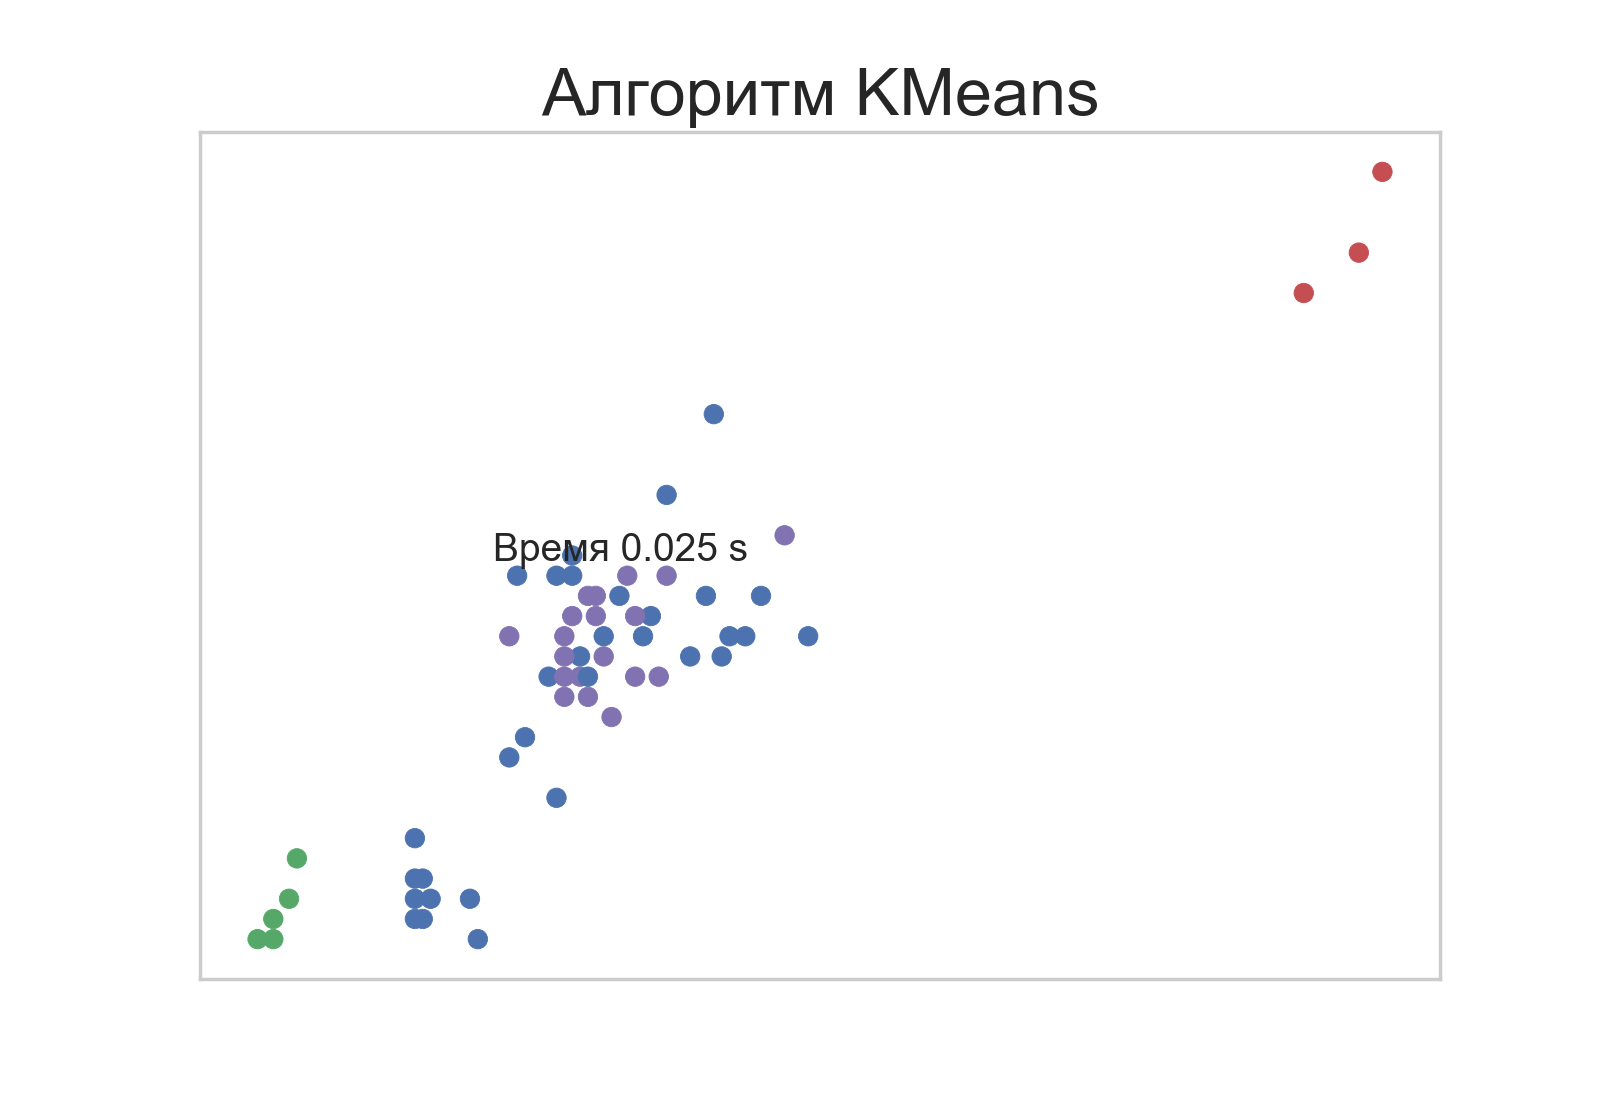

In [112]:
plot_clusters(X, cluster.KMeans, (), {'n_clusters':4})

Основные метрики оценки кластеризации-это distorsion_score и silhouette_score. Выбор количества кластеров осуществляется исходя из резкого изменения поведения функции на графике (в нашем примере, такое происходит при четырех кластерах).

<IPython.core.display.Javascript object>


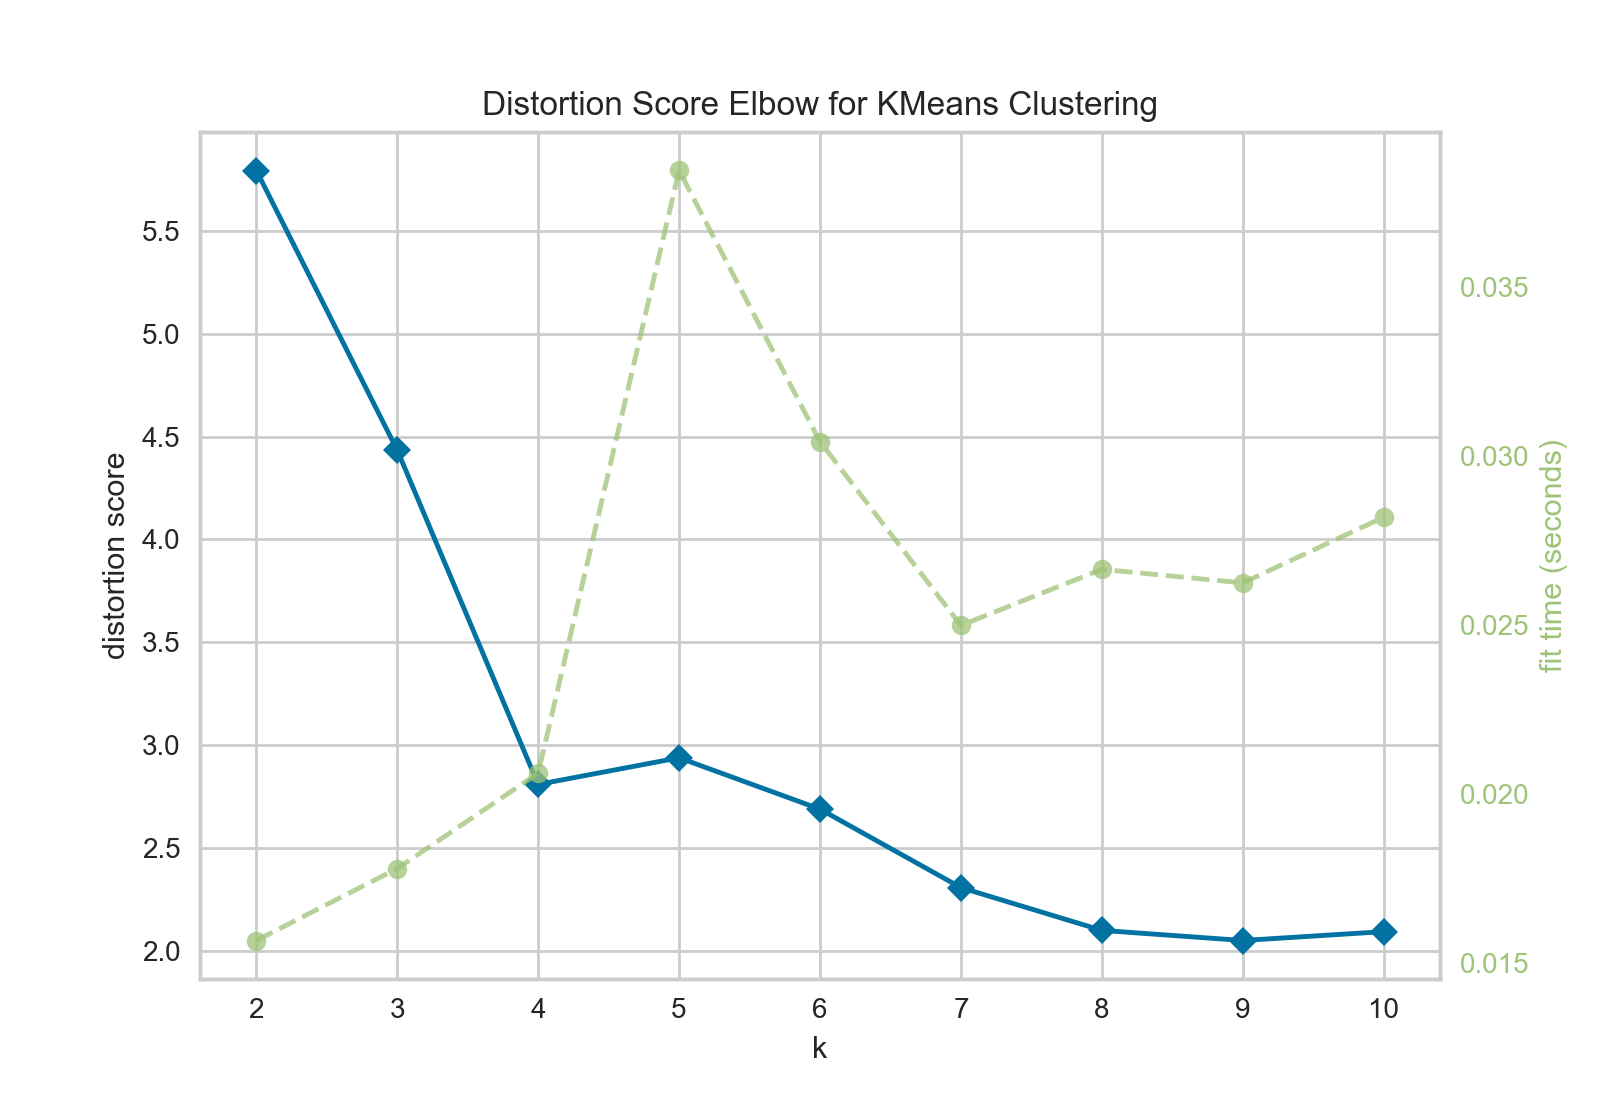

In [114]:
model = KElbowVisualizer(cluster.KMeans(), metric='distortion',  k=10)
model.fit(X)
model.poof()

<IPython.core.display.Javascript object>


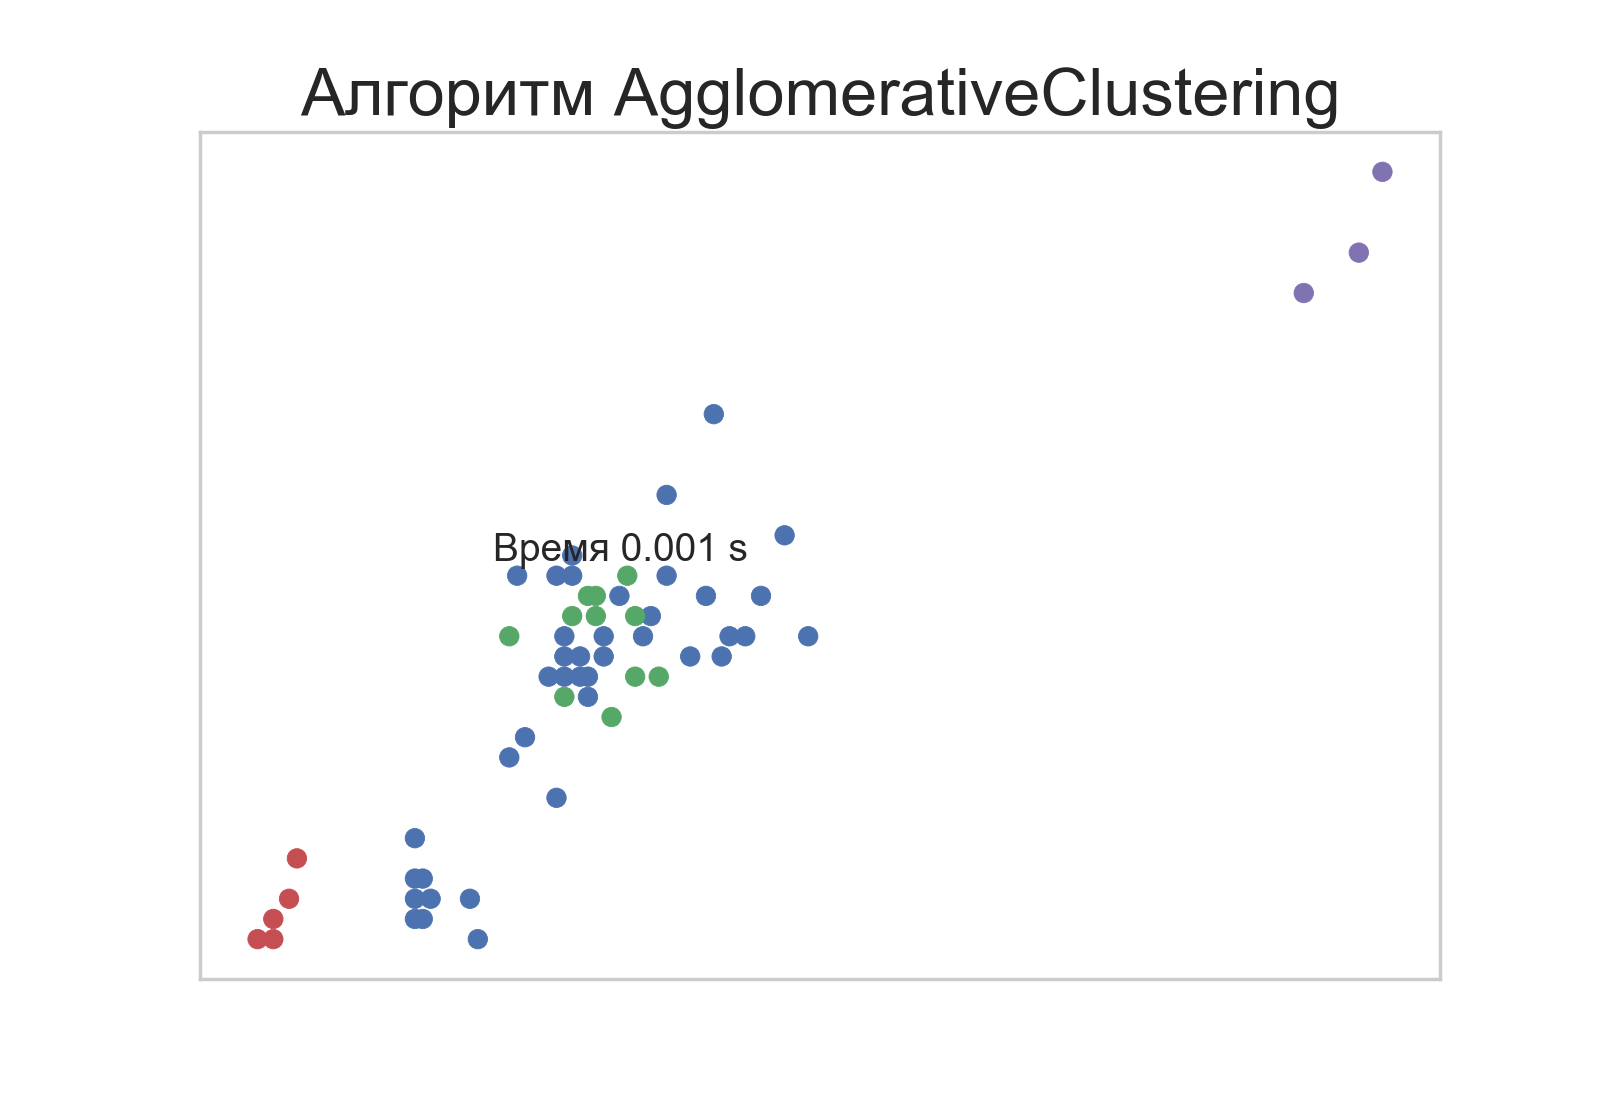

In [115]:
plot_clusters(X, cluster.AgglomerativeClustering, (), {'n_clusters':4, 'linkage':'ward'})

In [116]:
kmeans = cluster.KMeans(n_clusters=4, random_state=0).fit(X)

In [117]:
model=kmeans.labels_
model

array([0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 2, 2, 2, 0, 1, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 1, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [118]:
fruits['KM'] = pd.Series(model, index=fruits.index)

In [119]:
fruits

,fruit_label,fruit_name,mass,width,height,col_score,KM
0,1,apple,192,8.4,7.3,0.55,0
1,1,apple,180,8.0,6.8,0.59,0
2,1,apple,176,7.4,7.2,0.60,0
3,2,mandarin,86,6.2,4.7,0.80,1
4,2,mandarin,84,6.0,4.6,0.79,1
5,2,mandarin,80,5.8,4.3,0.77,1
6,2,mandarin,80,5.9,4.3,0.81,1
7,2,mandarin,76,5.8,4.0,0.81,1
8,1,apple,178,7.1,7.8,0.92,3
9,1,apple,172,7.4,7.0,0.89,3
